# Setup

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, get_scheduler, GPT2Config
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torchmetrics import F1Score

# Run

## 2-class calssifier

In [2]:
sentiments_data = pd.read_csv(r'LabelledNewsData.csv',encoding = "ISO-8859-1")

In [3]:
sentiments_data.head()

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0


In [4]:
dataset = Dataset.from_pandas(sentiments_data)

In [5]:
dataset

Dataset({
    features: ['datetime', 'headline', 'ticker', 'sentiment'],
    num_rows: 9470
})

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096")
model = GPT2ForSequenceClassification.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096")

# print the total number of parameters in millions (M)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.1f}M")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Total number of parameters: 81.9M


### Fine tune the model

#### Trial #1

Map:   0%|          | 0/9470 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 947/2841 [2:37:53<5:26:22, 10.34s/it]

Epoch 1/3: train loss 0.5493, val loss 0.2059, val accuracy 0.9145


 67%|██████▋   | 1894/2841 [5:14:09<2:18:45,  8.79s/it] 

Epoch 2/3: train loss 0.1719, val loss 0.1325, val accuracy 0.9609


100%|██████████| 2841/2841 [7:39:53<00:00,  8.81s/it]    

Epoch 3/3: train loss 0.1101, val loss 0.1091, val accuracy 0.9657


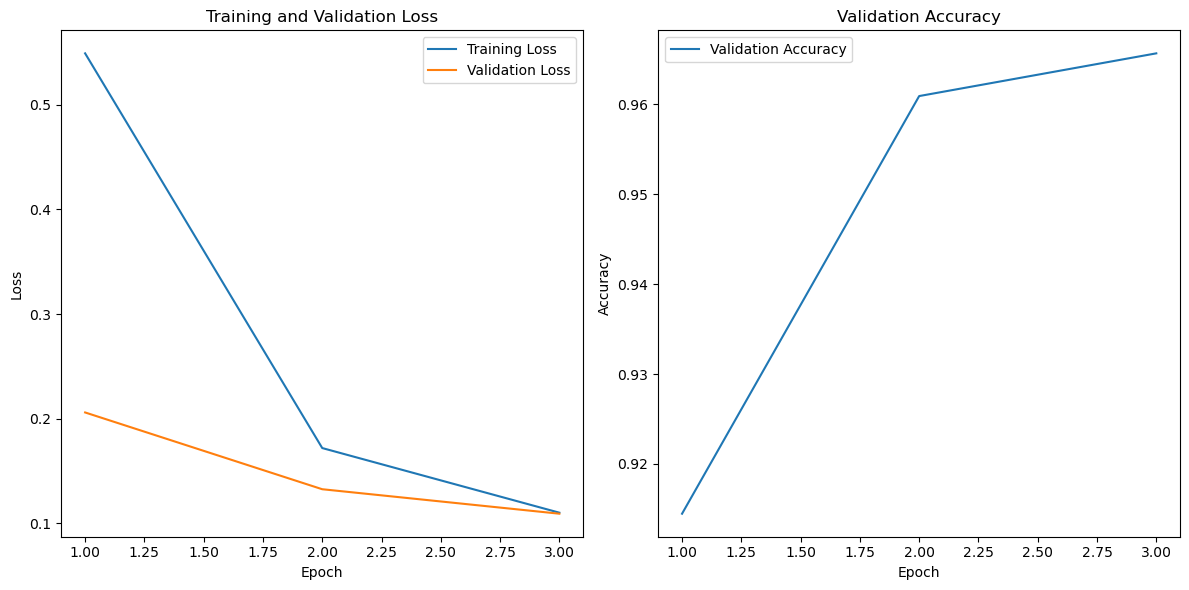

Final validation accuracy: 0.9657


In [7]:
# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096")
model = GPT2ForSequenceClassification.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["headline"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["datetime", "headline", "ticker"])
tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

In [9]:
modelsavename = "distilgpt2_9k_ep3_9657.pt"

# Save the model's state_dict
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

print(f"Model saved as {modelsavename}")

Model saved as distilgpt2_9k_ep3_9657.pt


In [13]:
def test_1(input_text):
  # Tokenize input and get model output
  inputs = tokenizer(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = model(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probs = softmax(logits, dim=1)

  # Map classes to polarity values
  polarity_values = torch.tensor([0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
  polarity_score = torch.sum(probs * polarity_values, dim=1).item()

#   polarity_score = 2*polarity_score - 1

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  print(f"Predicted class: {predicted_class}")
  print(f"Polarity score: {polarity_score:.2f}")

# Positive class
input_text = "The Bitcoin market will continue to grow"
test_1(input_text)

# Neutral class
input_text = "The Bitcoin market doesnot change"
test_1(input_text)

# Negative class
input_text = "The Bitcoin market is trending down"
test_1(input_text)

Predicted class: 1
Polarity score: 0.98
Predicted class: 1
Polarity score: 0.77
Predicted class: 0
Polarity score: 0.01


## 3-class calssifier

In [2]:
# Set a fixed random seed for reproducibility
random.seed(42)

# Load the dataset2 from Hugging Face
dataset2 = load_dataset("kisejin/finance_sentiment_dataset")

# Convert string labels to integers
label_mapping2 = {"negative": 0, "neutral": 1, "positive": 2}

# Split data by sentiment label
negative_samples2 = [sample for sample in dataset2["train"] if sample["output"] == "negative"]
positive_samples2 = [sample for sample in dataset2["train"] if sample["output"] == "positive"]
neutral_samples2 = [sample for sample in dataset2["train"] if sample["output"] == "neutral"]

# Get the number of negative samples to balance
num_samples = 3000 # len(negative_samples)

# Randomly select same number of positive and neutral samples
balanced_negative_samples2 = random.sample(negative_samples2, num_samples)
balanced_positive_samples2 = random.sample(positive_samples2, num_samples)
balanced_neutral_samples2 = random.sample(neutral_samples2, num_samples)

# Combine all into a new dataset2
balanced_dataset2 = balanced_negative_samples2 + balanced_positive_samples2 + balanced_neutral_samples2

# Convert 'output' field to integers
for sample in balanced_dataset2:
    sample['output'] = label_mapping2[sample['output']]

# Optional: Convert it to a Hugging Face dataset2 for compatibility
from datasets import Dataset
balanced_dataset2 = Dataset.from_dict({k: [d[k] for d in balanced_dataset2] for k in balanced_dataset2[0].keys()})

### Fine tune the model

#### Trial #1

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ANGKJ1995/distilgpt2-mbib-4096 and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [2:16:30<4:35:34,  9.19s/it]

Epoch 1/3: train loss 1.0119, val loss 0.6406, val accuracy 0.7367


 67%|██████▋   | 1800/2700 [4:42:36<2:23:17,  9.55s/it] 

Epoch 2/3: train loss 0.5981, val loss 0.4923, val accuracy 0.7989


100%|██████████| 2700/2700 [7:04:50<00:00,  8.96s/it]    

Epoch 3/3: train loss 0.4781, val loss 0.4597, val accuracy 0.8200


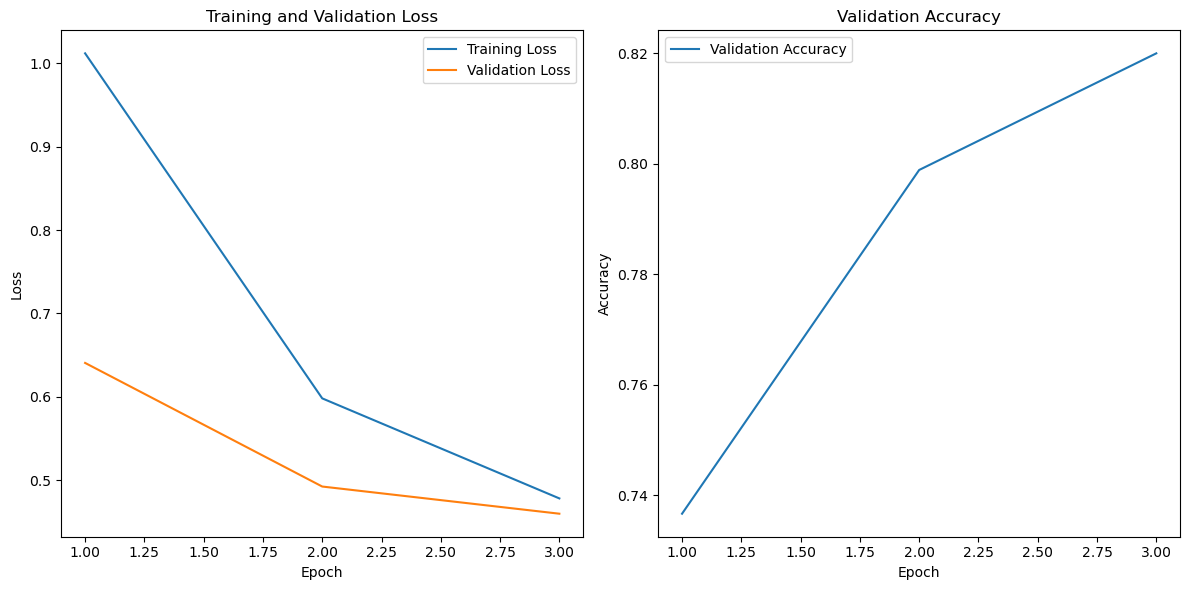

Final validation accuracy: 0.8200


In [5]:
# Load the tokenizer and model with three labels for multi-class classification
tokenizer = GPT2Tokenizer.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096")
model = GPT2ForSequenceClassification.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096", num_labels=3, ignore_mismatched_sizes=True)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset2.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

In [7]:
modelsavename = "distilgpt2_c3_9k_ep3_8200.pt"

# Save the model's state_dict
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

print(f"Model saved as {modelsavename}")

Model saved as distilgpt2_c3_9k_ep3_8200.pt


#### Trial #2 (use F1)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ANGKJ1995/distilgpt2-mbib-4096 and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 20%|██        | 900/4500 [2:58:44<8:53:18,  8.89s/it] 

Epoch 1/5: train loss 0.9323, val loss 0.6279, val accuracy 0.7456


 40%|████      | 1800/4500 [5:55:43<9:25:37, 12.57s/it]  

Epoch 2/5: train loss 0.5486, val loss 0.4435, val accuracy 0.8330


 60%|██████    | 2700/4500 [9:05:10<5:47:24, 11.58s/it]   

Epoch 3/5: train loss 0.4028, val loss 0.3863, val accuracy 0.8577


 80%|████████  | 3600/4500 [12:09:24<2:56:49, 11.79s/it] 

Epoch 4/5: train loss 0.3211, val loss 0.3720, val accuracy 0.8669


100%|██████████| 4500/4500 [14:46:50<00:00,  9.31s/it]    

Epoch 5/5: train loss 0.2782, val loss 0.3682, val accuracy 0.8705


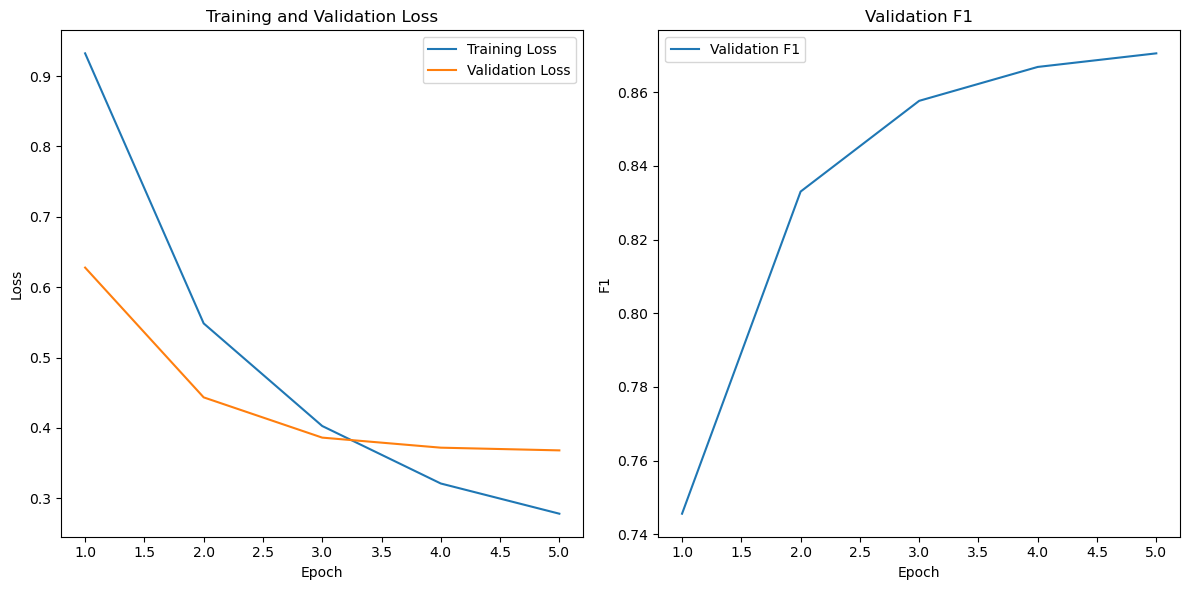

Final validation F1: 0.8705


In [3]:
# Load the tokenizer and model2 with three labels for multi-class classification
tokenizer2 = GPT2Tokenizer.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096")
model2 = GPT2ForSequenceClassification.from_pretrained("ANGKJ1995/distilgpt2-mbib-4096", num_labels=3, ignore_mismatched_sizes=True)

# Tokenization function
def tokenize_function(examples):
    return tokenizer2(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets2 = balanced_dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["instruction", "input"])
tokenized_datasets2 = tokenized_datasets2.rename_column("output", "labels")
tokenized_datasets2.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset2 = tokenized_datasets2.shuffle(seed=42)
train_size2 = int(0.8 * len(shuffled_train_dataset2))  # 80% for training
small_train_dataset2 = shuffled_train_dataset2.select(range(train_size2))
small_eval_dataset2 = shuffled_train_dataset2.select(range(train_size2, len(shuffled_train_dataset2)))

# Dataloaders
train_dataloader2 = DataLoader(small_train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(small_eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 5
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=3, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

In [5]:
modelsavename2 = "distilgpt2_c3_9k_ep3_f1_8705.pt"

# Save the model's state_dict
with open(modelsavename2, "wb") as f:
    torch.save(model2.state_dict(), f)

print(f"Model saved as {modelsavename2}")

Model saved as distilgpt2_c3_9k_ep3_f1_8705.pt


#### Trial #3 (new model, use F1)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [5:20:32<10:12:19, 20.41s/it]

Epoch 1/3: train loss 0.7383, val loss 0.4873, val accuracy 0.8140


 67%|██████▋   | 1800/2700 [10:58:09<5:21:12, 21.41s/it] 

Epoch 2/3: train loss 0.4381, val loss 0.4038, val accuracy 0.8342


100%|██████████| 2700/2700 [16:37:16<00:00, 21.86s/it]    

Epoch 3/3: train loss 0.3498, val loss 0.3820, val accuracy 0.8500


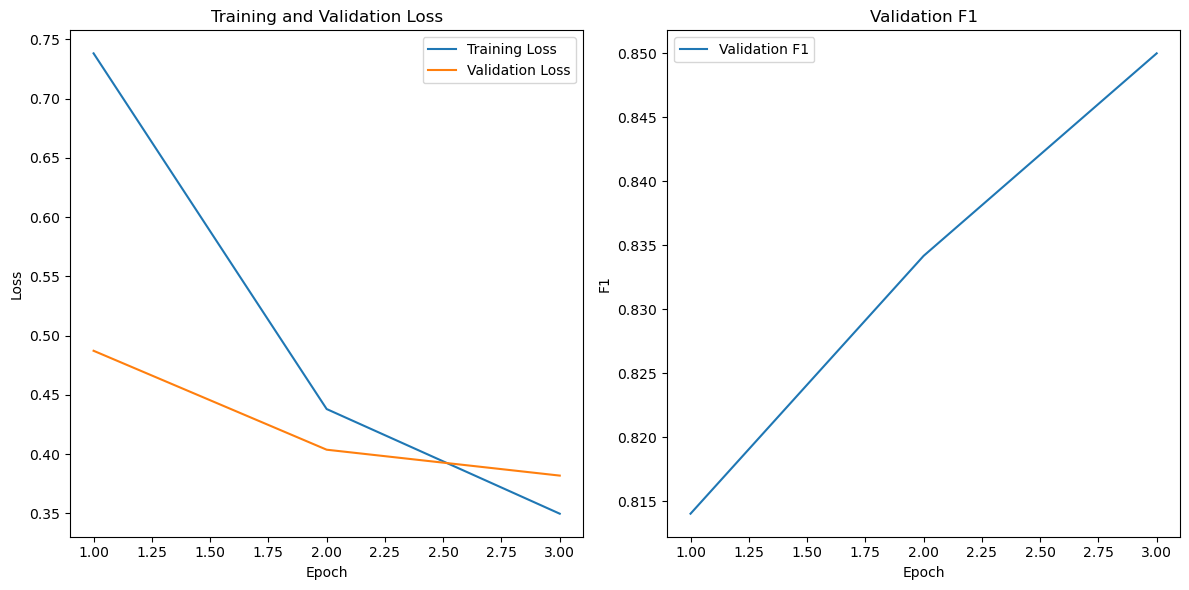

Final validation F1: 0.8500


In [4]:
# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", config=configuration2
).to(device2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer2(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets2 = balanced_dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["instruction", "input"])
tokenized_datasets2 = tokenized_datasets2.rename_column("output", "labels")
tokenized_datasets2.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset2 = tokenized_datasets2.shuffle(seed=42)
train_size2 = int(0.8 * len(shuffled_train_dataset2))  # 80% for training
small_train_dataset2 = shuffled_train_dataset2.select(range(train_size2))
small_eval_dataset2 = shuffled_train_dataset2.select(range(train_size2, len(shuffled_train_dataset2)))

# Dataloaders
train_dataloader2 = DataLoader(small_train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(small_eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 3
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=3, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

In [6]:
modelsavename2 = "gpt2_c3_9k_ep3_f1_8500.pt"

# Save the model's state_dict
with open(modelsavename2, "wb") as f:
    torch.save(model2.state_dict(), f)

print(f"Model saved as {modelsavename2}")

Model saved as gpt2_c3_9k_ep3_f1_8500.pt


In [3]:
test_model_name = "gpt2_c3_9k_ep3_f1_8500.pt"

test_config = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
test_model = GPT2ForSequenceClassification.from_pretrained("Harshad018/trained-gpt2-tweet-analysis", config=test_config)

test_model.load_state_dict(torch.load(test_model_name))

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_65807/1148713068.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

<All keys matched successfully>

In [5]:
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")

In [8]:
def test_1(input_text):
  # Tokenize input and get model output
  inputs = tokenizer2(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = test_model(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probs = softmax(logits, dim=1)

  # Map classes to polarity values
  polarity_values = torch.tensor([-1.0, 0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
  polarity_score = torch.sum(probs * polarity_values, dim=1).item()

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  print(f"Predicted class: {predicted_class}")
  print(f"Polarity score: {polarity_score:.2f}")

# Positive class
input_text = "The Bitcoin market will increase by 20%"
test_1(input_text)

# Neutral class
input_text = "The Bitcoin market will remain steady"
test_1(input_text)

# Negative class
input_text = "The Bitcoin market is trending down"
test_1(input_text)

Predicted class: 2
Polarity score: 0.90
Predicted class: 1
Polarity score: -0.11
Predicted class: 0
Polarity score: -0.97


#### Trial #4 (continue to tune gpt2_c3_9k_ep3_f1_8500.pt)

In [3]:
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_69779/4229690575.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 50%|█████     | 900/1800 [5:33:24<5:31:45, 22.12s/it] 

Epoch 1/2: train loss 0.3159, val loss 0.3496, val accuracy 0.8653


100%|██████████| 1800/1800 [11:23:27<00:00, 22.53s/it]  

Epoch 2/2: train loss 0.2290, val loss 0.3280, val accuracy 0.8785


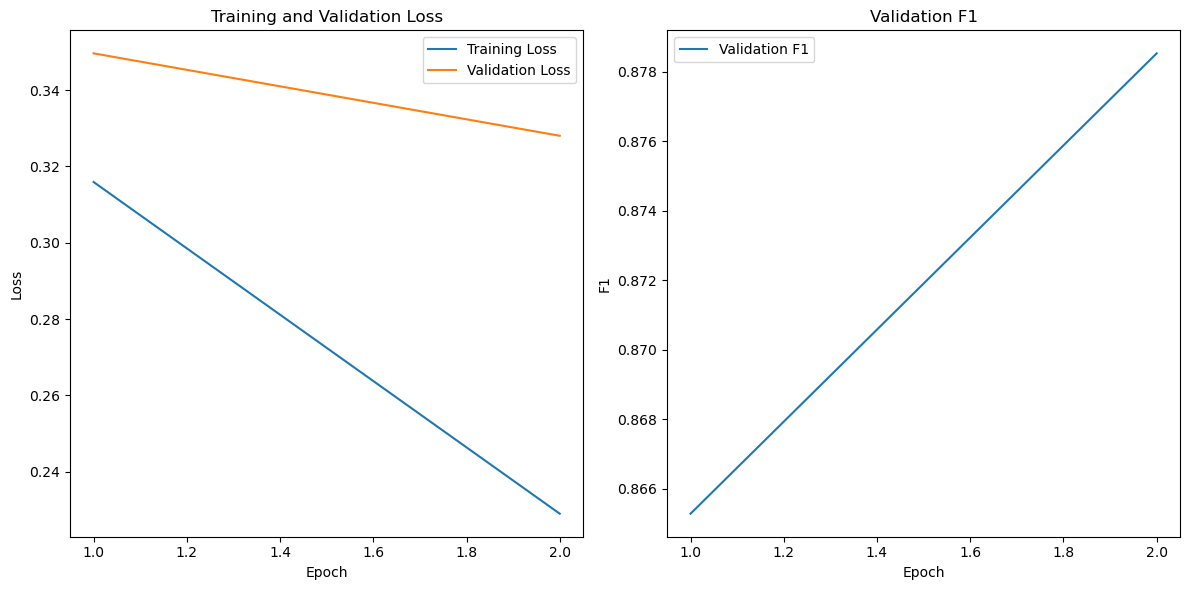

Final validation F1: 0.8785


In [3]:
# Move model2 to device (GPU if available)
# device2 = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", config=configuration2
).to(device2)

model2.load_state_dict(torch.load("gpt2_c3_9k_ep3_f1_8500.pt"))
model2.to(device2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer2(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets2 = balanced_dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["instruction", "input"])
tokenized_datasets2 = tokenized_datasets2.rename_column("output", "labels")
tokenized_datasets2.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset2 = tokenized_datasets2.shuffle(seed=42)
train_size2 = int(0.8 * len(shuffled_train_dataset2))  # 80% for training
small_train_dataset2 = shuffled_train_dataset2.select(range(train_size2))
small_eval_dataset2 = shuffled_train_dataset2.select(range(train_size2, len(shuffled_train_dataset2)))

# Dataloaders
train_dataloader2 = DataLoader(small_train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(small_eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 2
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=3, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

In [4]:
modelsavename2 = "gpt2_c3_9k_ep2_f1_8785.pt"

# Save the model's state_dict
with open(modelsavename2, "wb") as f:
    torch.save(model2.state_dict(), f)

print(f"Model saved as {modelsavename2}")

Model saved as gpt2_c3_9k_ep2_f1_8785.pt


#### Trial #4 (continue to tune gpt2_c3_9k_ep2_f1_8785.pt)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/vx/57ntql9x3lg7fsldp3xp6w1c0000gn/T/ipykernel_95767/2672118270.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 50%|█████     | 900/1800 [6:55:26<8:09:52, 32.66s/it] 

Epoch 1/2: train loss 0.2120, val loss 0.3323, val accuracy 0.8836


100%|██████████| 1800/1800 [13:23:04<00:00, 21.12s/it]   

Epoch 2/2: train loss 0.1447, val loss 0.3180, val accuracy 0.8887


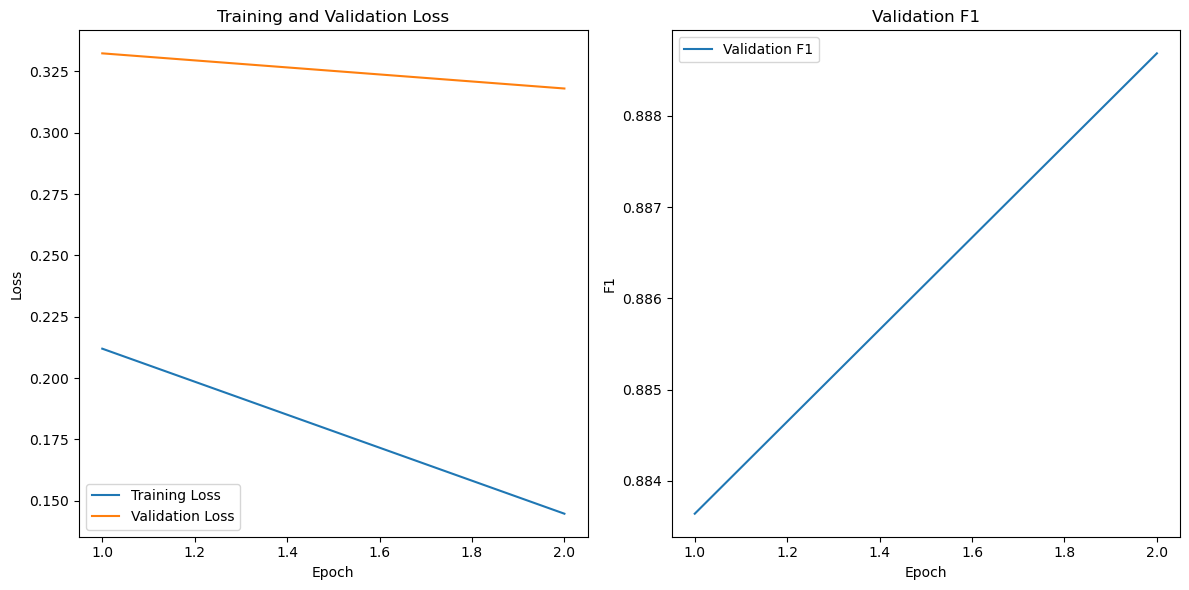

Final validation F1: 0.8887


In [4]:
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", config=configuration2
).to(device2)

model2.load_state_dict(torch.load("gpt2_c3_9k_ep2_f1_8785.pt"))
model2.to(device2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer2(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets2 = balanced_dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["instruction", "input"])
tokenized_datasets2 = tokenized_datasets2.rename_column("output", "labels")
tokenized_datasets2.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset2 = tokenized_datasets2.shuffle(seed=42)
train_size2 = int(0.8 * len(shuffled_train_dataset2))  # 80% for training
small_train_dataset2 = shuffled_train_dataset2.select(range(train_size2))
small_eval_dataset2 = shuffled_train_dataset2.select(range(train_size2, len(shuffled_train_dataset2)))

# Dataloaders
train_dataloader2 = DataLoader(small_train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(small_eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 2
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=3, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

In [6]:
modelsavename2 = "gpt2_c3_9k_ep2_f1_8887.pt"

# Save the model's state_dict
with open(modelsavename2, "wb") as f:
    torch.save(model2.state_dict(), f)

print(f"Model saved as {modelsavename2}")

Model saved as gpt2_c3_9k_ep2_f1_8887.pt
